In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from sklearn.cluster import MeanShift

from PIL import Image
import cv2
import warnings
warnings.filterwarnings(action='once')
new_size = 100,100

def do_meanshift(img):
    img_mat = np.array(img)[:, :, :3]

    # Extract the three colour channels
    red = img_mat[:, :, 0]
    green = img_mat[:, :, 1]
    blue = img_mat[:, :, 2]

    # Store the shape so we can reshape later
    original_shape = green.shape
    colour_samples = np.column_stack([red.flatten(), green.flatten(), blue.flatten()])

    ms_clf = MeanShift(bin_seeding=True)
    ms_labels = ms_clf.fit_predict(colour_samples).reshape(original_shape)
    return ms_labels





def plot_three_images(figure_title, image1, label1,image2, label2, image3, label3):
    fig = plt.figure()
    fig.suptitle(figure_title)

    # Display the first image
    fig.add_subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(label1)

    # Display the second image
    fig.add_subplot(1, 3, 2)
    plt.imshow(image2)
    plt.axis('off')
    plt.title(label2)

    # Display the third image
    fig.add_subplot(1, 3, 3)
    plt.imshow(image3)
    plt.axis('off')
    plt.title(label3)

def plot_two_images(figure_title, image1, label1,
                      image2, label2):
    fig = plt.figure()
    fig.suptitle(figure_title)

    # Display the first image
    fig.add_subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(label1)

    # Display the second image
    fig.add_subplot(1, 2, 2)
    plt.imshow(image2)
    plt.axis('off')
    plt.title(label2)

def green(image):
    ## convert to hsv
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    ## mask of green (36,25,25) ~ (86, 255,255)
    # mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
    mask = cv2.inRange(hsv, (36, 30, 30), (75, 255,255))

    ## slice the green
    imask = mask>0
    green = np.zeros_like(image, np.uint8)
    green[imask] = image[imask]

    ## save 
    # cv2.imwrite("green.png", green)


    fig = plt.gcf()
    fig.set_size_inches(40,40)
    plt.subplot(211),plt.imshow(image),plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(212),plt.imshow(green),plt.title('green')
    plt.xticks([]), plt.yticks([])
    plt.show()
    
    return green

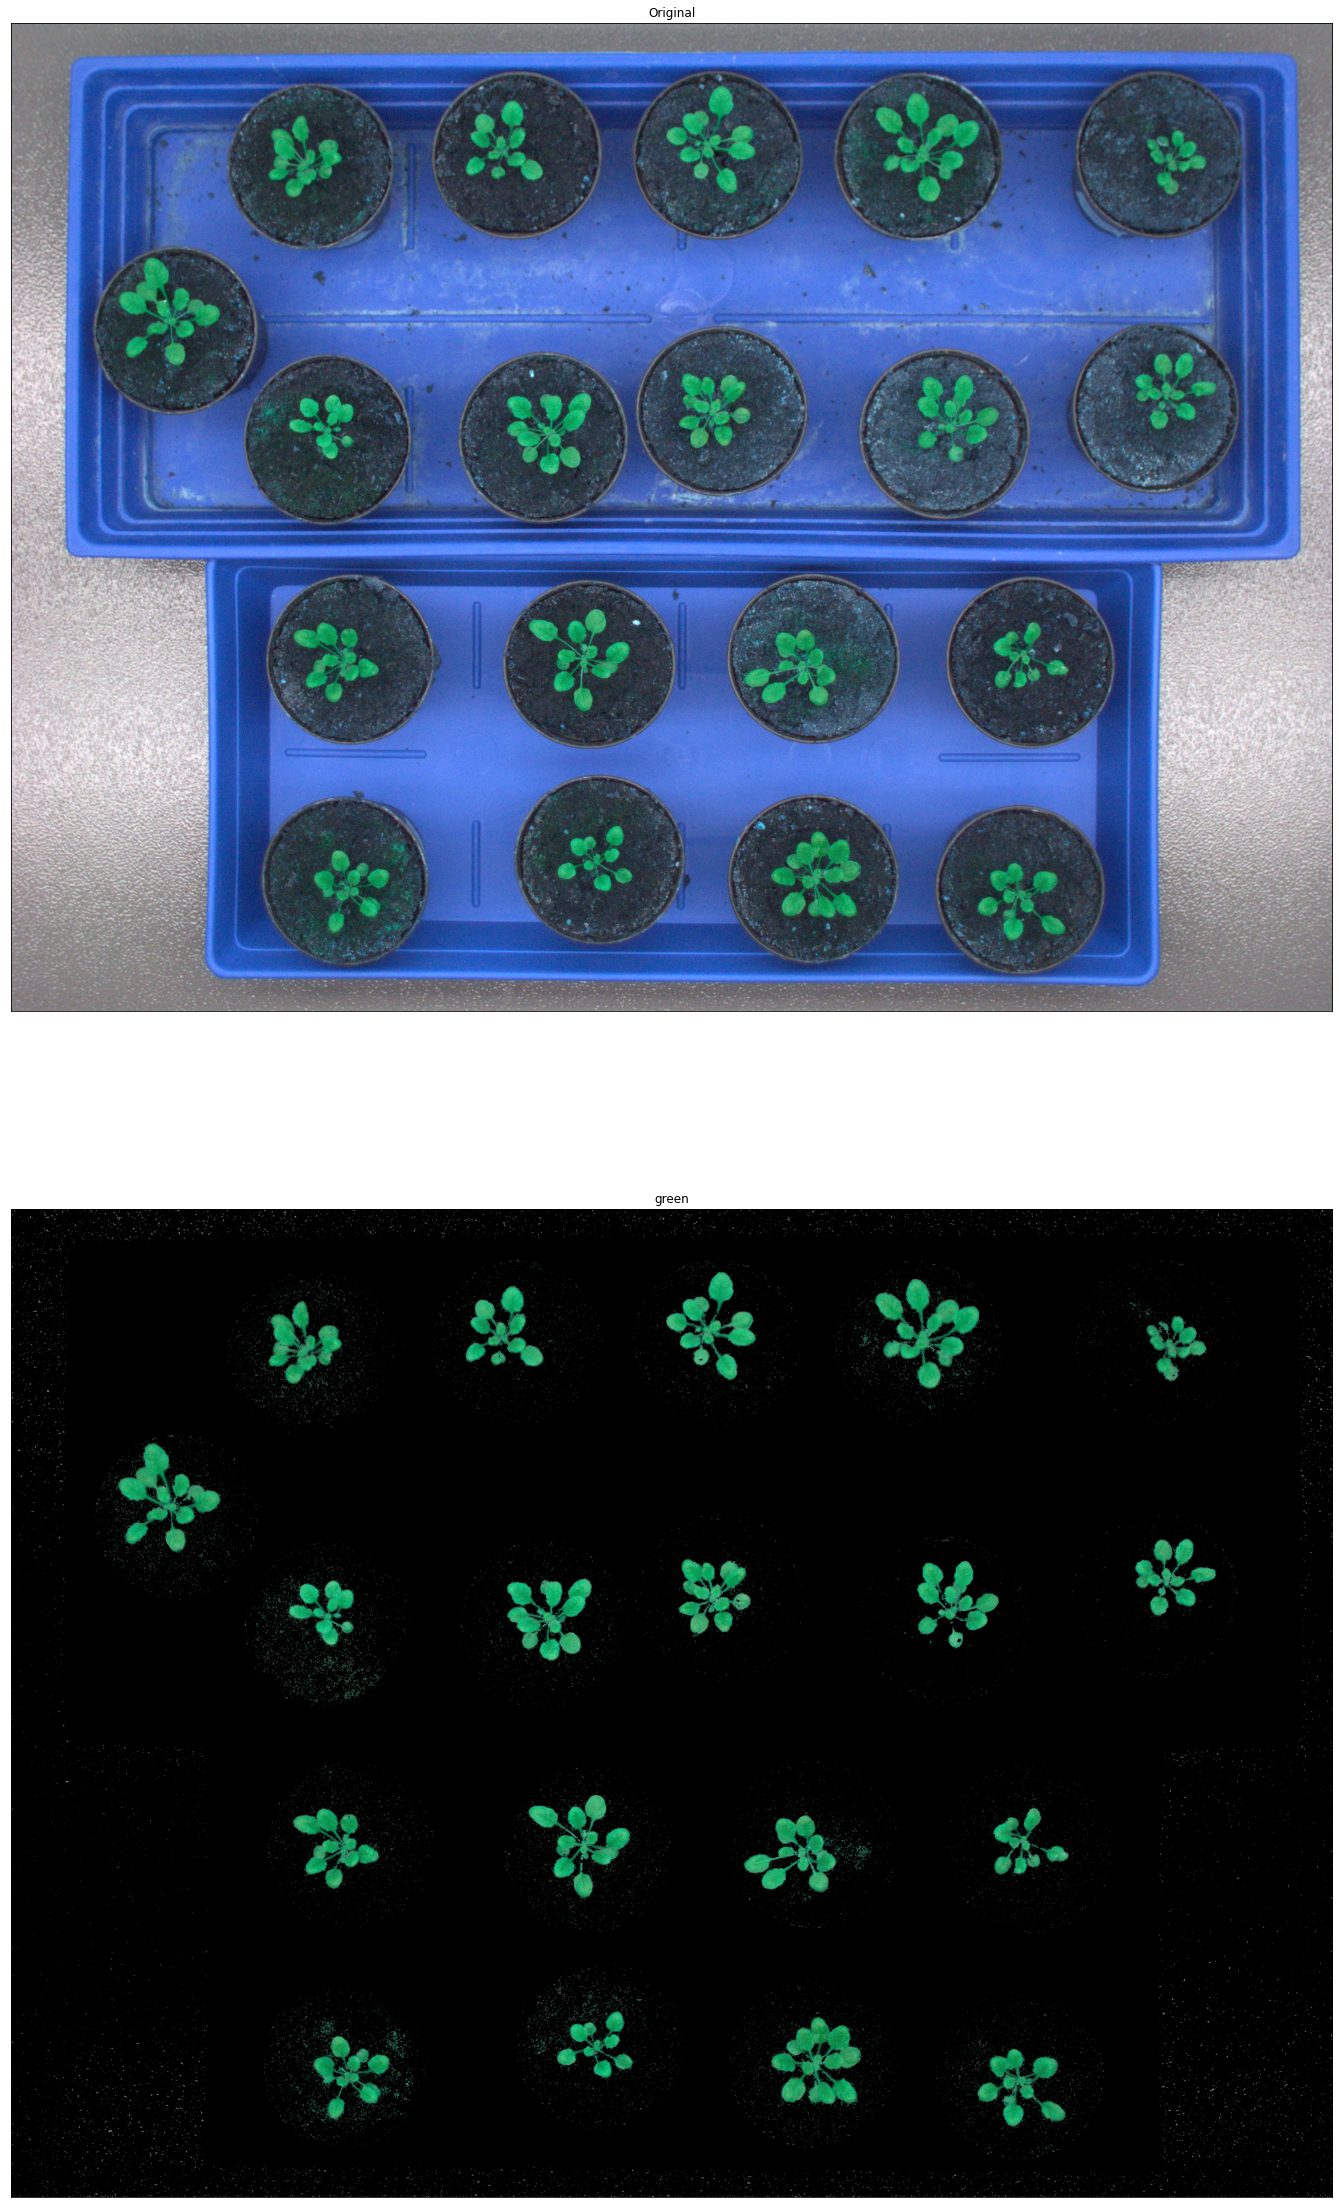

In [5]:
image_BGR = cv2.imread("ara2012_tray01_rgb.png")
image_RGB = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
image = green(image_BGR)

In [6]:
def do_watershed(img):
    # Convert the image to greyscale
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Convert to binary image (note: can also use cv thresholding)
    img_array = cv2.threshold(img_grey, 20, 255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1] 
    distance = ndi.distance_transform_edt(img_array)
    
    # Both implemetations of peak_local_max will work, but will produce
    # different outputs. Both are acceptable.
    local_maxi = peak_local_max(distance, indices=False,
                                footprint=np.ones((7, 7)),
                                labels=img_array)
    # local_maxi = peak_local_max(distance, indices=False)
                                
    markers = ndi.label(local_maxi)[0]
    ws_labels = watershed(-distance, markers, mask=img_array)
    #print("Distance:", distance)
    return ws_labels, distance

In [7]:
def resize(img,per):
    scale_percent = per # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

(-0.5, 3107.5, 2323.5, -0.5)

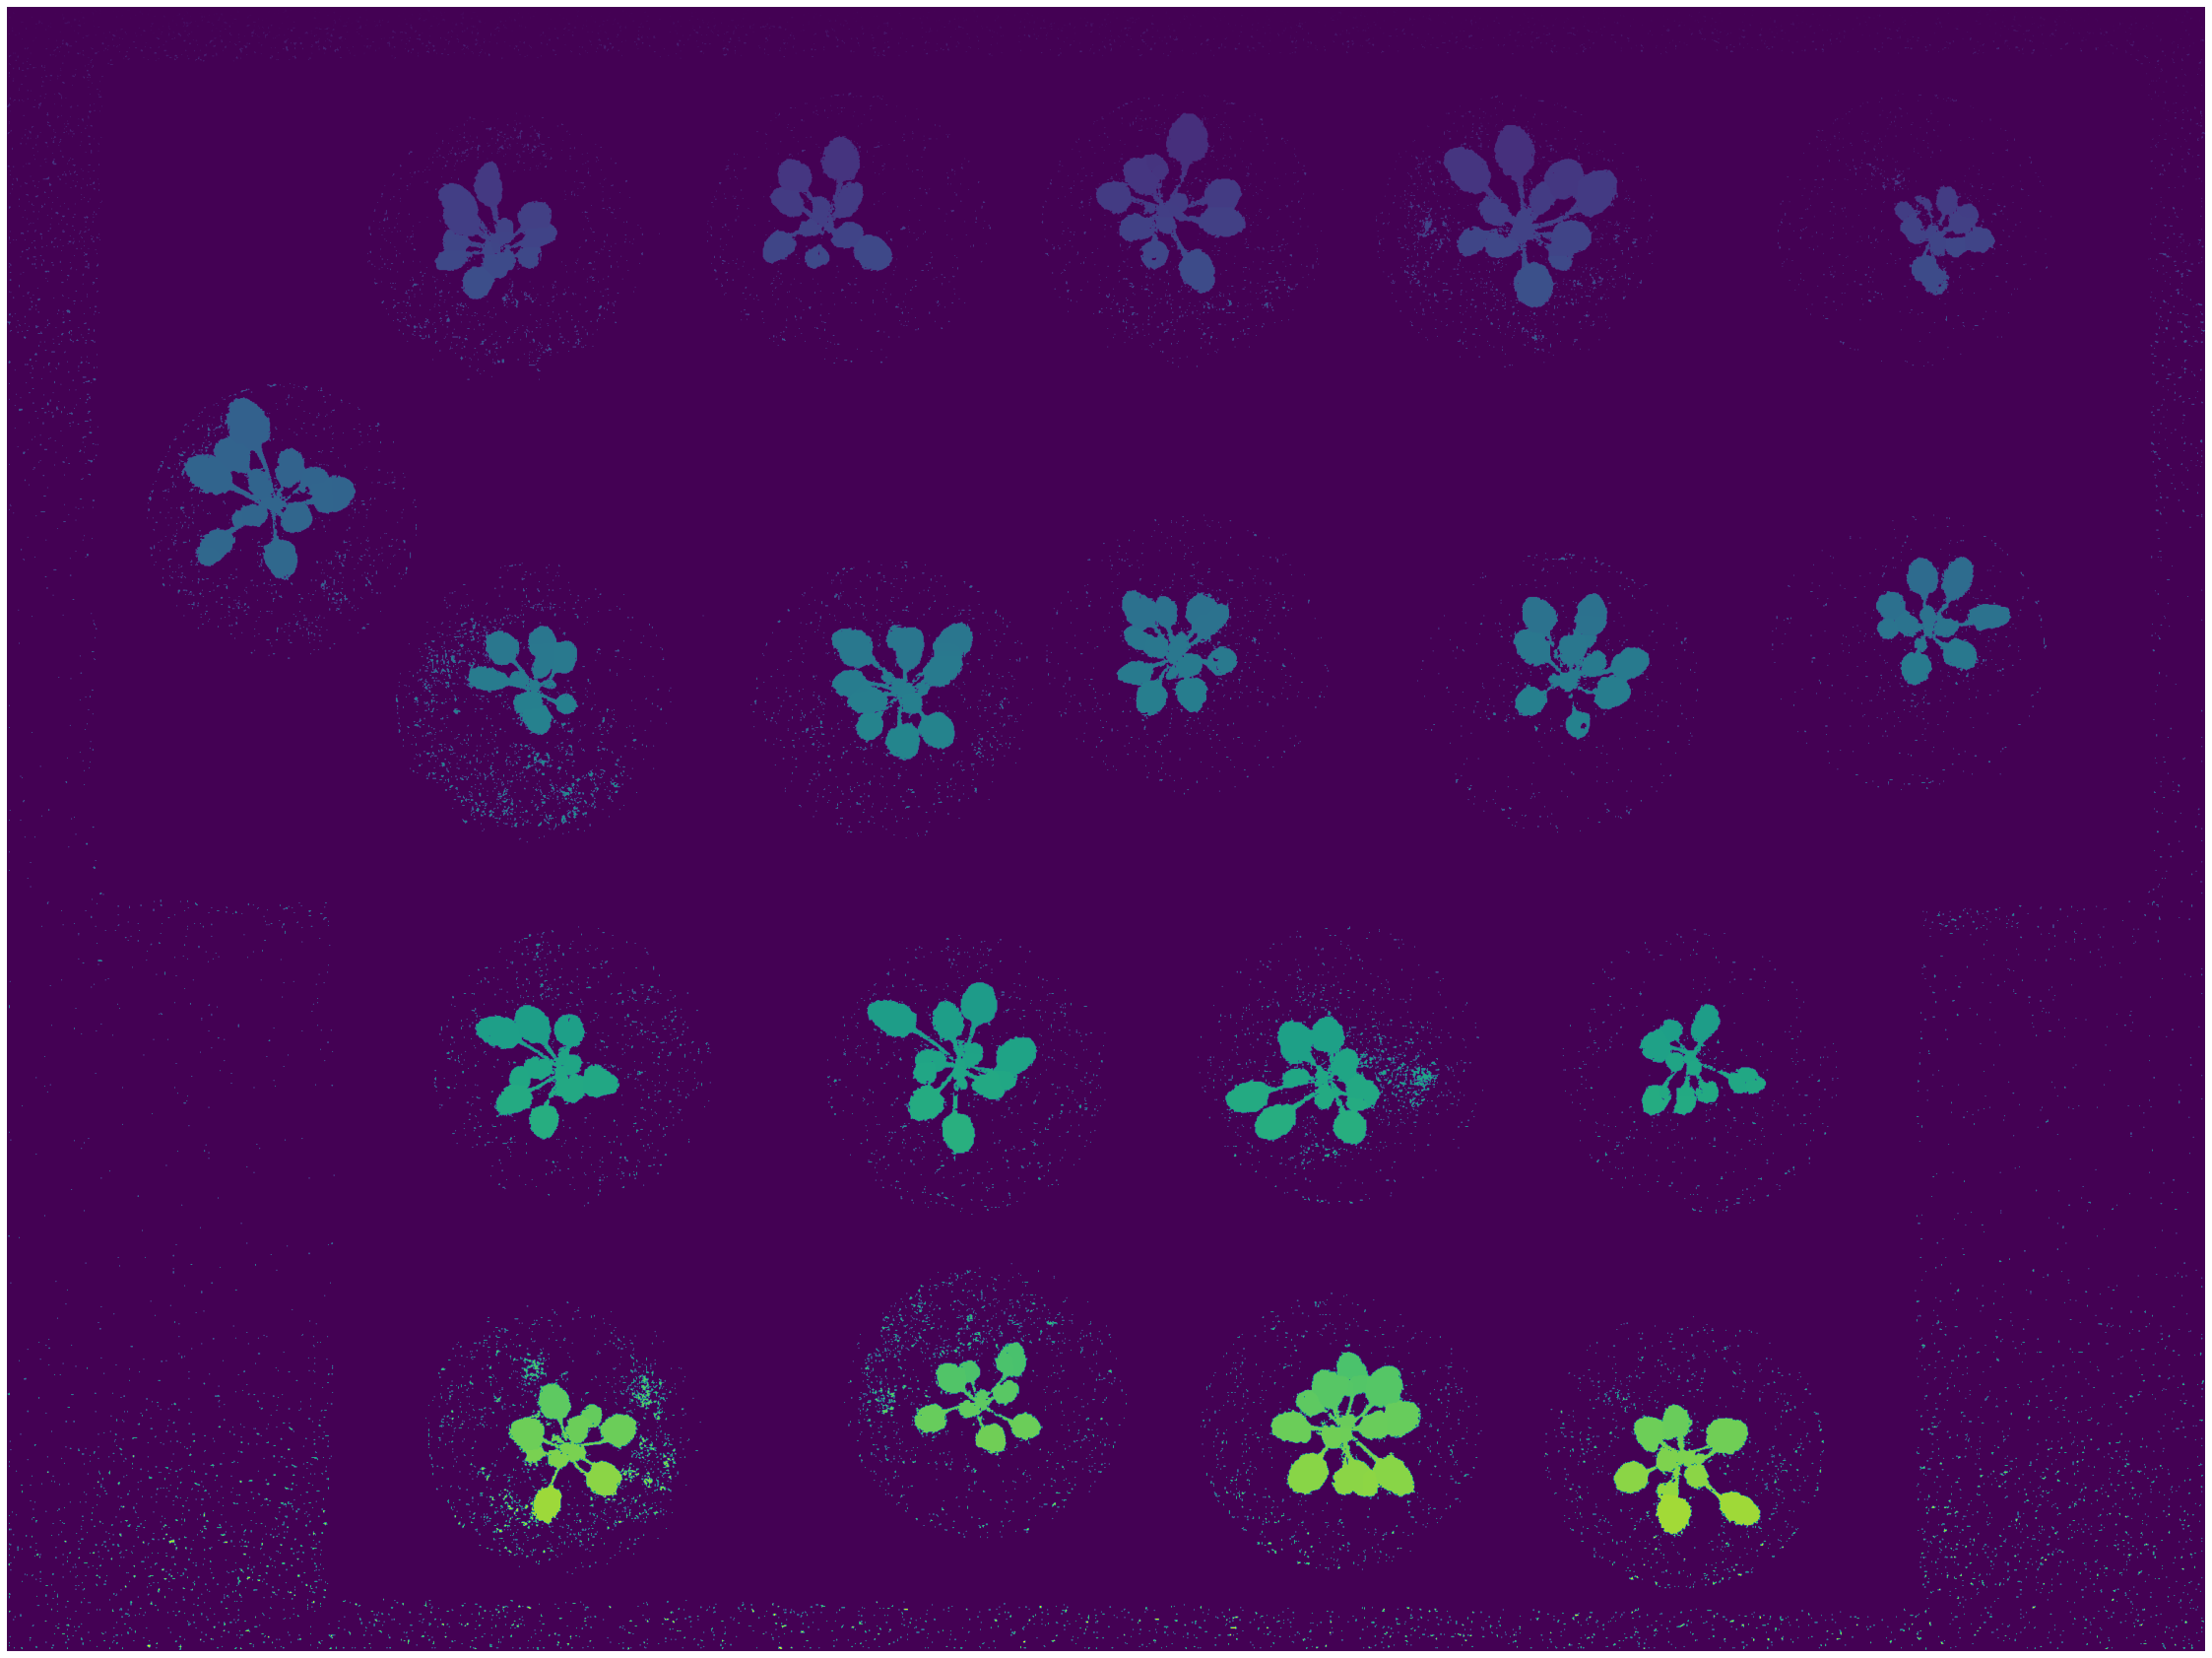

In [11]:

# image = cv2.imread(image_BGR)
# REsizing image to reduce execution time
#Meanshift and watershed
# mean =do_meanshift(resize(image_BGR,5))
ws_labels, distance = do_watershed(image)
fig = plt.gcf()
fig.set_size_inches(40,40)
plt.imshow(ws_labels)
plt.axis('off')

(-0.5, 3107.5, 2323.5, -0.5)

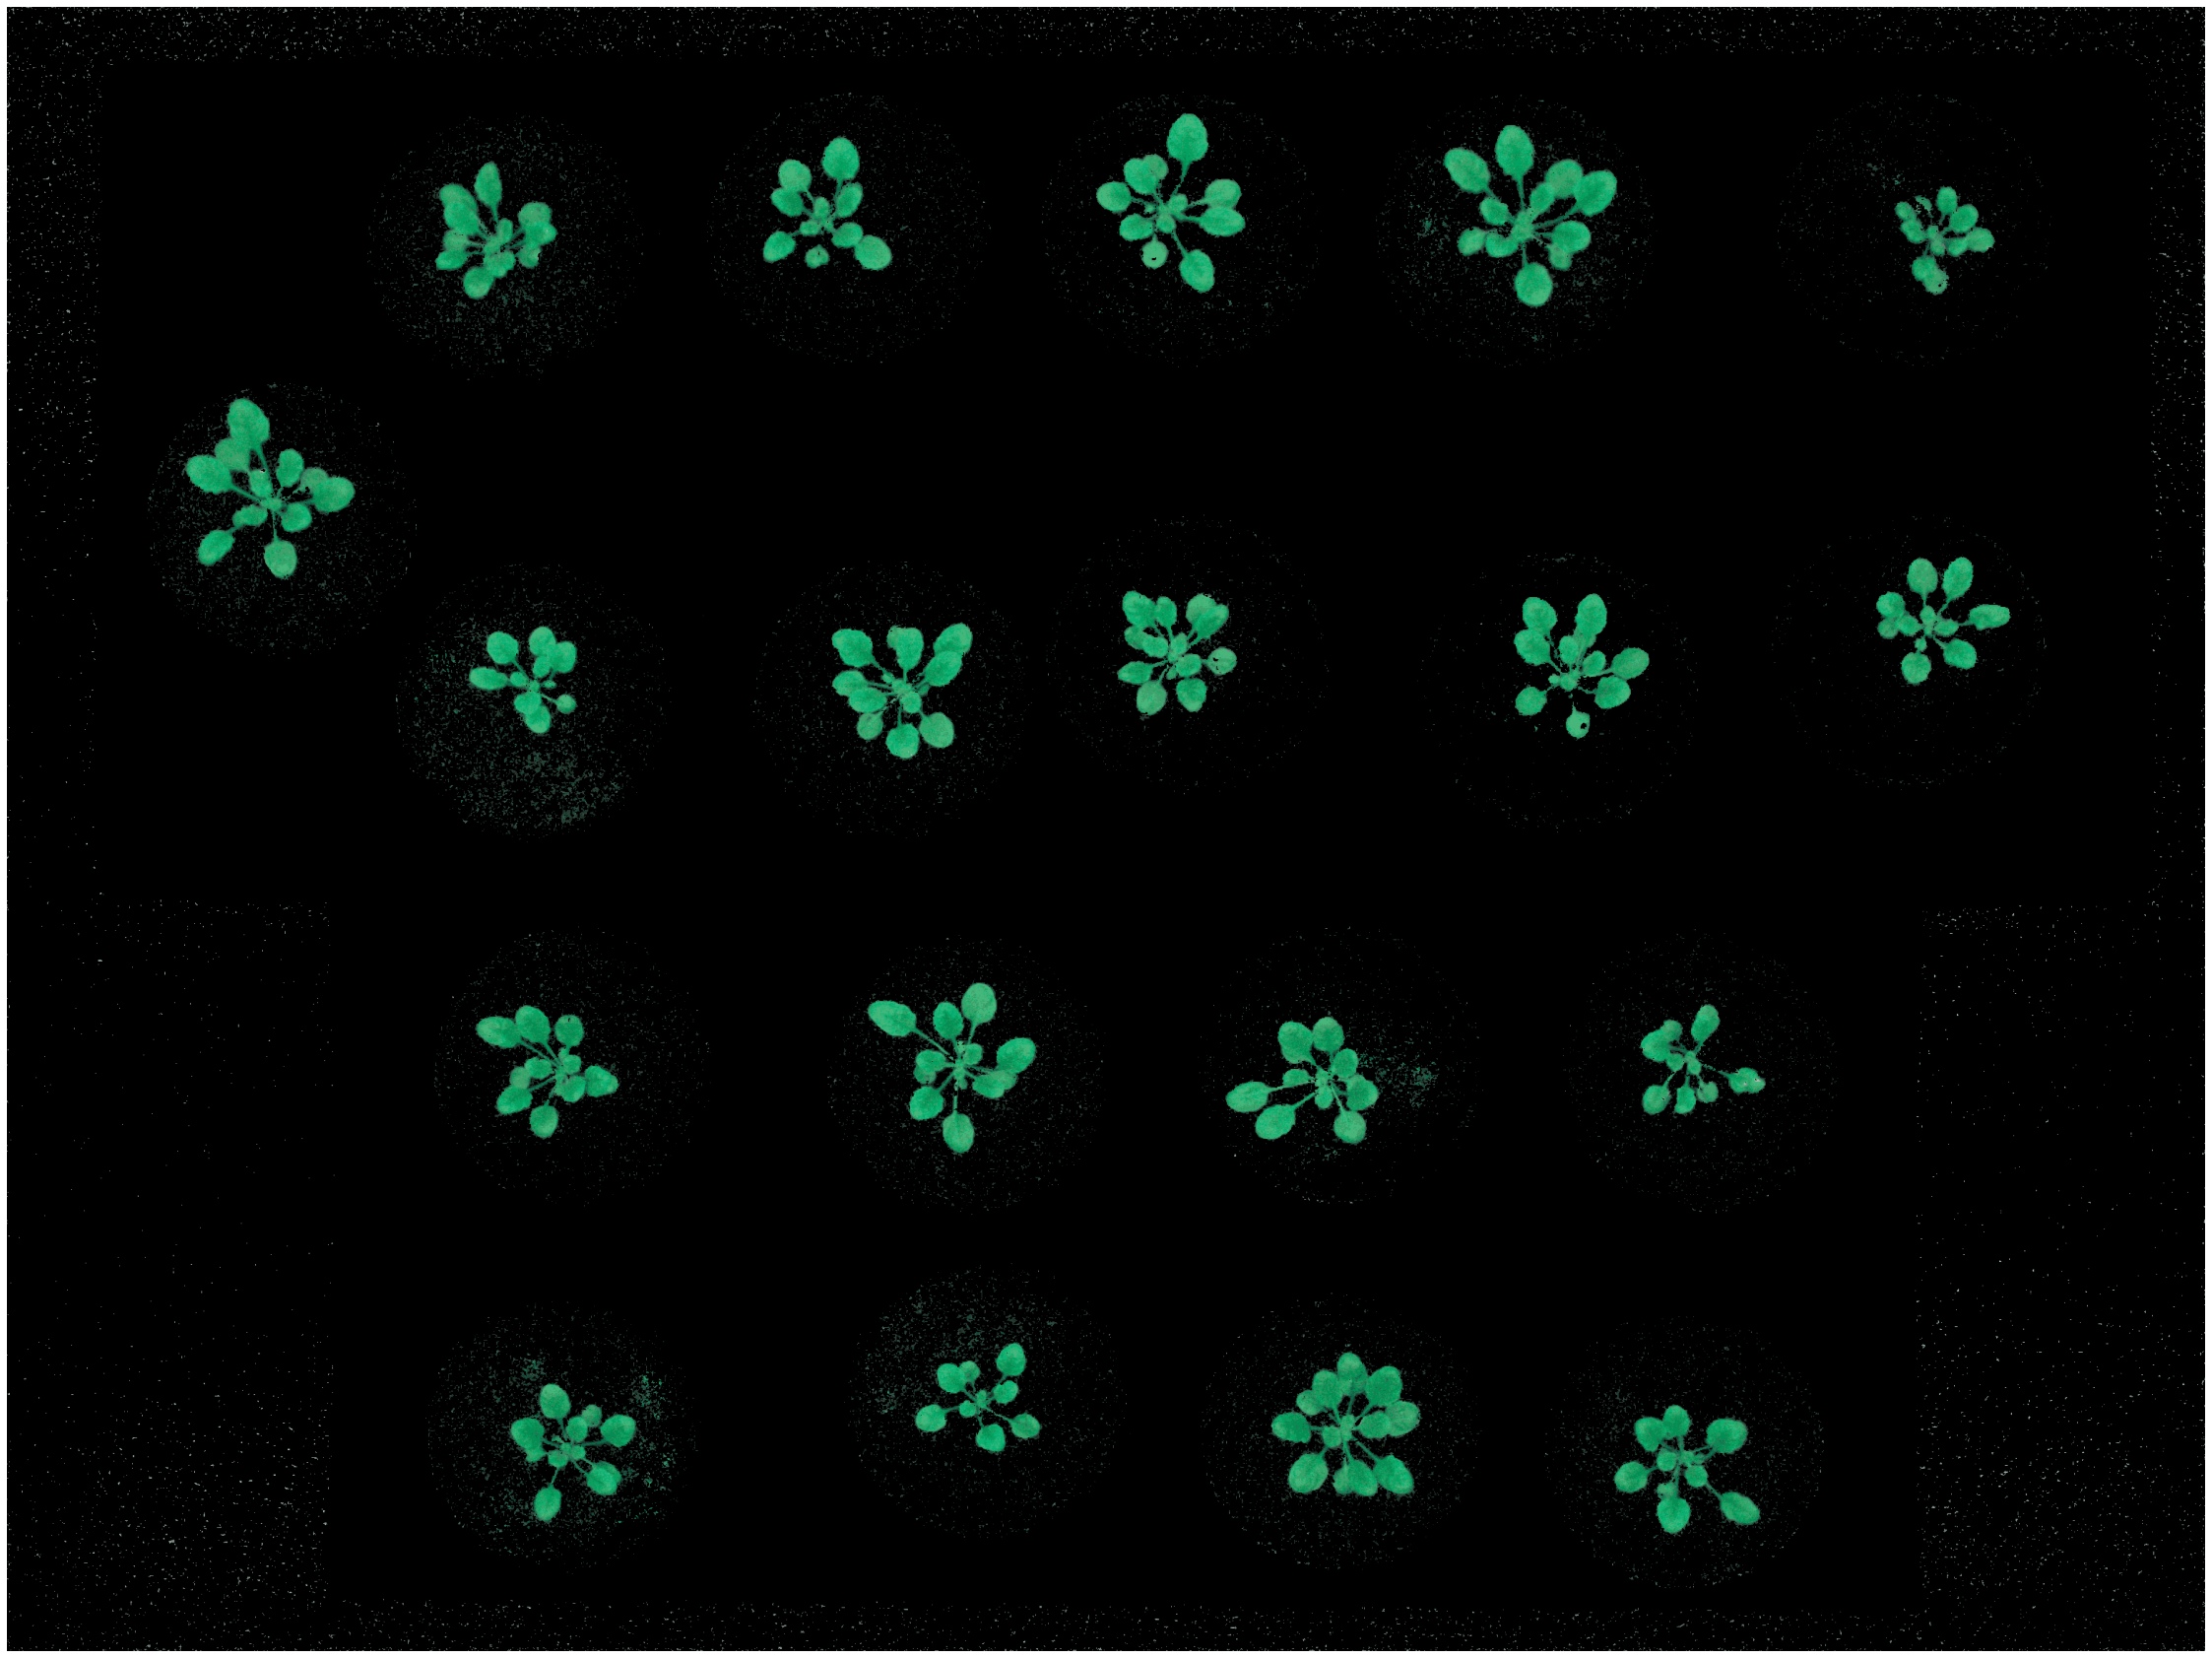

In [16]:
image2 = image.reshape((-1,3))
image2 = np.float32(image2)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,10,1.0)
k=19
attempts = 10
ret,label,center = cv2.kmeans(image2,k,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image.shape))
fig = plt.gcf()
fig.set_size_inches(40,40)
plt.imshow(res2)
plt.axis('off')